In [91]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from scipy import stats
import requests

Find whether there is a correlation between nsp6 deletion (3675-3677) and a higher number of S1 mutations

In [32]:
#Download tree json
tree_url = "https://data.nextstrain.org/ncov_global.json"

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

In [33]:
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path

In [46]:
#Find the path from root to internal node and accumulate all mutations that have occurred along this path
#Keep track of these for RdRp and store it as a node attribute

def consolidate_deletions(mutation_list):
    """
    For deletion mutations, consider adjacent sites as part of the same deletion
    """
    mutation_count = len([x for x in mutation_list if x[-1]!='-'])
    deletions_only = sorted([int(x[1:-1]) for x in mutation_list if x[-1]=='-'])

    # if there are deletions, count a run of consecutive sites as a single deletion/mutation
    if len(deletions_only) != 0:
        mutation_count+=1

        deletion_tracker = deletions_only[0]
        for deleted_pos in deletions_only[1:]:
            if deleted_pos == deletion_tracker+1:
                pass
            else:
                mutation_count+=1
            deletion_tracker = deleted_pos
    return mutation_count

def remove_reversions(mutation_list):
    """
    If site mutates and then reverts, do not count this in the mutation tally.
    If site mutates and then mutates again (but not a reversion), count only the second mutation
    """
    mutation_list_pos = [int(x[1:-1]) for x in mutation_list]
    sites_mutated_twice = set([x for x in mutation_list_pos if mutation_list_pos.count(x) > 1])
    # find if twice-mutated site was a reversion
    for site in sites_mutated_twice:
        muts_at_site = [mut for mut in mutation_list if int(mut[1:-1])==site]

        # if site reverts, remove all mutations at this site
        if muts_at_site[0][0] == muts_at_site[-1][-1]:
            for mut in range(len(muts_at_site)):
                mutation_list.remove(muts_at_site[mut])
        # if the site mutates multiple times, but doesn't revert, keep last mutation
        else:
            for mut in range(len(muts_at_site)-1):
                mutation_list.remove(muts_at_site[mut])
    return mutation_list
    
    


for node in tree.find_clades():

    
    #Find all parents of the node
    parents = get_parent(tree, node)

    #Find rdrp mutations that occur in the parents
    parents_rdrp_muts = []

    for parent in parents:
        if hasattr(parent, "branch_attrs") and "mutations" in parent.branch_attrs:
            #find RdRp muts
            if "ORF1a" in parent.branch_attrs["mutations"]:
                for mut in parent.branch_attrs["mutations"]["ORF1a"]:
                    if int(mut[1:-1]) in range(4492,4401):
                        #renumber mut according to rdrp protein
                        rdrp_mut = f'{mut[0]}{int(mut[1:-1])-4492}{mut[-1]}'
                        parents_rdrp_muts+=[rdrp_mut]
            elif "ORF1b" in parent.branch_attrs["mutations"]:
                for mut in parent.branch_attrs["mutations"]["ORF1b"]:
                    if int(mut[1:-1]) in range(1,923):
                        #renumber mut according to rdrp protein
                        rdrp_mut = f'{mut[0]}{int(mut[1:-1])+9}{mut[-1]}'
                        parents_rdrp_muts+=[rdrp_mut]

    # remove reversion mutations from each list
    parents_rdrp_muts = remove_reversions(parents_rdrp_muts)



    # count deletion of adjacent nucleotides as one mutation event
    rdrp_mutation_count = consolidate_deletions(parents_rdrp_muts)


    node.node_attrs["rdrp_muts"] = rdrp_mutation_count

In [75]:
def final_pos_genotype(mutation_list, mutation):
    """
    Given a list of mutations that occurred at certain position, 
    find the whether the final genotype at this position is the specified mutation or not (return True or False)
    """

    
    if len(mutation_list) == 0:
        mutation_at_pos = False 
        
    elif len(mutation_list) == 1:
        if mutation_list[0][-1] == mutation:
            mutation_at_pos = True
        else:
            mutation_at_pos = False 
        
    
    elif len(mutation_list) > 1:
        if mutation_list[-1][-1] == mutation:
            mutation_at_pos = True
        else:
            mutation_at_pos = False 


    return mutation_at_pos

In [134]:
to_plot = []

for node in tree.find_clades(terminal=False):
    
    if "S1_mutations" in node.node_attrs:
        s1_mutations = node.node_attrs["S1_mutations"]["value"]
        rdrp_mutations =  node.node_attrs["rdrp_muts"]
        date = node.node_attrs["num_date"]["value"]
    
        #Find all parents of the node
        parents = get_parent(tree, node)

        #Find mutations that occur in the parents
        parents_3676_muts = []
        parents_3255_muts = []
        parents_N205_muts = []
        parents_N234_muts = []
        parents_S501_muts = []
        parents_S452_muts = []


        for parent in parents:
            if hasattr(parent, "branch_attrs") and "mutations" in parent.branch_attrs:
                #find specific mutations of interest
                if "ORF1a" in parent.branch_attrs["mutations"]:
                    for mut in parent.branch_attrs["mutations"]["ORF1a"]:
                        if int(mut[1:-1])==3676:
                            parents_3676_muts+=[mut]
                        elif int(mut[1:-1]) == 3255:
                            parents_3255_muts+=[mut]
                            
                elif "N" in parent.branch_attrs["mutations"]:
                    for mut in parent.branch_attrs["mutations"]["N"]:
                        if int(mut[1:-1])==205:
                            parents_N205_muts+=[mut]
                        elif int(mut[1:-1])==234:
                            parents_N234_muts+=[mut]
                elif "S" in parent.branch_attrs["mutations"]:
                    for mut in parent.branch_attrs["mutations"]["S"]:
                        if int(mut[1:-1])==501:
                            parents_S501_muts+=[mut]
                        elif int(mut[1:-1])==452:
                            parents_S452_muts+=[mut]


        # remove reversion mutations from each list and get final genotype at 3676
        deletion_at_3676 = final_pos_genotype(parents_3676_muts, '-')
        
        mutation_at_3255 = final_pos_genotype(parents_3255_muts, 'I')
        
        mutation_at_N205 = final_pos_genotype(parents_N205_muts, 'I')
        
        mutation_at_N234 = final_pos_genotype(parents_N234_muts, 'I')
        
        mutation_at_S501 = final_pos_genotype(parents_S501_muts, 'Y')
        
        mutation_at_S452 = final_pos_genotype(parents_S452_muts, 'R')
        
        if 'emerging_lineage' in node.node_attrs:
            emerging_lineage = node.node_attrs['emerging_lineage']['value']
          
        
        to_plot.append({'clade': node.name, 
                        'nsp6_deletion': deletion_at_3676, 
                        'nsp4_3255i': mutation_at_3255,
                        'N_205i': mutation_at_N205,
                        'N_234i': mutation_at_N234,
                        'S_501y': mutation_at_S501,
                        'S_452r': mutation_at_S452,
                        's1_mutations': s1_mutations, 
                        'rdrp_mutations':rdrp_mutations,
                        'emerging_lineage': emerging_lineage, 
                        'date': date})

to_plot_df = pd.DataFrame(to_plot)

Find the mean number of S1 and RdRp mutations that lineages with and without Nsp6 deletion have

In [90]:
mean_s1_nsp6del = to_plot_df[to_plot_df['nsp6_deletion']==True]['s1_mutations'].mean()
mean_s1_no_nsp6del = to_plot_df[to_plot_df['nsp6_deletion']==False]['s1_mutations'].mean()
mean_rdrp_nsp6del = to_plot_df[to_plot_df['nsp6_deletion']==True]['rdrp_mutations'].mean()
mean_rdrp_no_nsp6del = to_plot_df[to_plot_df['nsp6_deletion']==False]['rdrp_mutations'].mean()

print(mean_s1_nsp6del, mean_s1_no_nsp6del)
print(mean_rdrp_nspdel, mean_rdrp_no_nsp6del)

6.574782608695652 1.8462694041061591
1.1530434782608696 0.9899849774661993


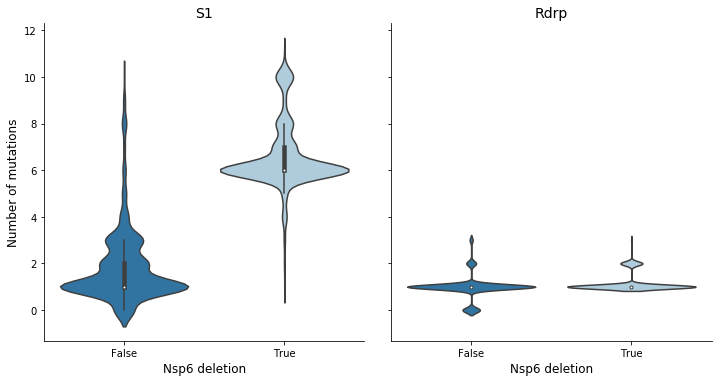

In [120]:
cmap = {True: "#a6cee3", False: "#1f78b4"}

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)
plt.tight_layout()


ax1 = sns.violinplot(x='nsp6_deletion', y='s1_mutations', 
                     hue = 'nsp6_deletion', palette = cmap, dodge = False,
                     data=to_plot_df, ax=ax1, legend = False)

ax2 = sns.violinplot(x='nsp6_deletion', y='rdrp_mutations', 
                     hue = 'nsp6_deletion', palette = cmap, dodge = False,
                     data=to_plot_df, ax=ax2, legend= False)

ax1.set_xlabel('Nsp6 deletion', fontsize = 12)
ax2.set_xlabel('Nsp6 deletion', fontsize = 12)

ax1.set_ylabel('Number of mutations', fontsize = 12)
ax2.set_ylabel('', fontsize = 12)
ax1.set_title('S1', fontsize = 14)
ax2.set_title('Rdrp', fontsize = 14)

sns.despine(left=False, bottom=False)


ax1.legend([],[], frameon=False)
ax2.legend([],[], frameon=False)

Consider only lineages that occurred at the same time or after the first Nsp6 deletion

In [126]:
date_subset = to_plot_df[to_plot_df['date']>=2020.5]

mean_s1_nsp6del_limit_time = date_subset[date_subset['nsp6_deletion']==True]['s1_mutations'].mean()
mean_s1_no_nsp6del_limit_time = date_subset[date_subset['nsp6_deletion']==False]['s1_mutations'].mean()
mean_rdrp_nsp6del_limit_time = date_subset[date_subset['nsp6_deletion']==True]['rdrp_mutations'].mean()
mean_rdrp_no_nsp6del_limit_time = date_subset[date_subset['nsp6_deletion']==False]['rdrp_mutations'].mean()

print(mean_s1_nsp6del_limit_time, mean_s1_no_nsp6del_limit_time)
print(mean_rdrp_nsp6del_limit_time, mean_rdrp_no_nsp6del_limit_time)

6.5956331877729255 2.6305555555555555
1.1537117903930132 1.1009259259259259


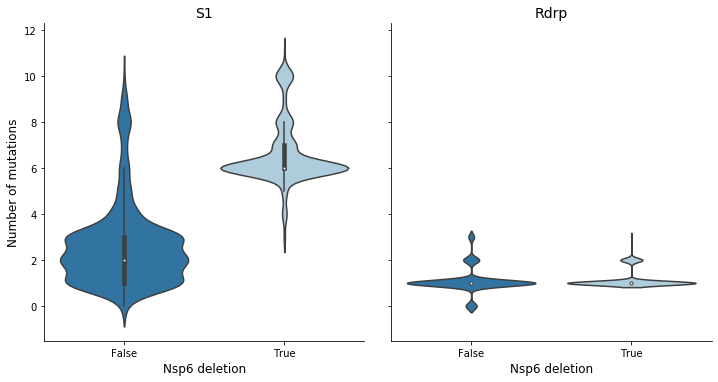

In [127]:
cmap = {True: "#a6cee3", False: "#1f78b4"}

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)
plt.tight_layout()


ax1 = sns.violinplot(x='nsp6_deletion', y='s1_mutations', 
                     hue = 'nsp6_deletion', palette = cmap, dodge = False,
                     data=date_subset, ax=ax1, legend = False)

ax2 = sns.violinplot(x='nsp6_deletion', y='rdrp_mutations', 
                     hue = 'nsp6_deletion', palette = cmap, dodge = False,
                     data=date_subset, ax=ax2, legend= False)

ax1.set_xlabel('Nsp6 deletion', fontsize = 12)
ax2.set_xlabel('Nsp6 deletion', fontsize = 12)

ax1.set_ylabel('Number of mutations', fontsize = 12)
ax2.set_ylabel('', fontsize = 12)
ax1.set_title('S1', fontsize = 14)
ax2.set_title('Rdrp', fontsize = 14)

sns.despine(left=False, bottom=False)


ax1.legend([],[], frameon=False)
ax2.legend([],[], frameon=False)

Do the same for Nsp4 3255I mutation, and Nucleocapsid 205I and 234I mutations

In [128]:
mean_s1_nsp4mut = date_subset[date_subset['nsp4_3255i']==True]['s1_mutations'].mean()
mean_s1_no_nsp4mut = date_subset[date_subset['nsp4_3255i']==False]['s1_mutations'].mean()
mean_rdrp_nsp4mut = date_subset[date_subset['nsp4_3255i']==True]['rdrp_mutations'].mean()
mean_rdrp_no_nsp4mut = date_subset[date_subset['nsp4_3255i']==False]['rdrp_mutations'].mean()

print(mean_s1_nsp4mut, mean_s1_no_nsp4mut)
print(mean_rdrp_nsp4mut, mean_rdrp_no_nsp4mut)

4.112426035502959 4.716926070038911
0.9644970414201184 1.1415369649805447


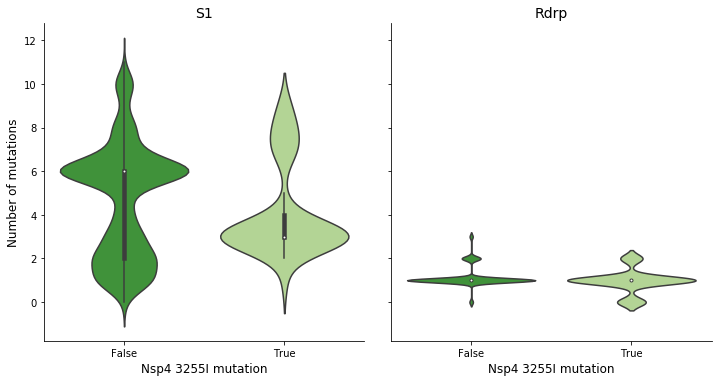

In [129]:
cmap = {True: "#b2df8a", False: "#33a02c"}

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)
plt.tight_layout()


ax1 = sns.violinplot(x='nsp4_3255i', y='s1_mutations', 
                     hue = 'nsp4_3255i', palette = cmap, dodge = False,
                     data=date_subset, ax=ax1, legend = False)

ax2 = sns.violinplot(x='nsp4_3255i', y='rdrp_mutations', 
                     hue = 'nsp4_3255i', palette = cmap, dodge = False,
                     data=date_subset, ax=ax2, legend= False)

ax1.set_xlabel('Nsp4 3255I mutation', fontsize = 12)
ax2.set_xlabel('Nsp4 3255I mutation', fontsize = 12)

ax1.set_ylabel('Number of mutations', fontsize = 12)
ax2.set_ylabel('', fontsize = 12)
ax1.set_title('S1', fontsize = 14)
ax2.set_title('Rdrp', fontsize = 14)

sns.despine(left=False, bottom=False)


ax1.legend([],[], frameon=False)
ax2.legend([],[], frameon=False)

In [130]:
mean_s1_N205i = date_subset[date_subset['N_205i']==True]['s1_mutations'].mean()
mean_s1_no_N205i = date_subset[date_subset['N_205i']==False]['s1_mutations'].mean()
mean_rdrp_N205i = date_subset[date_subset['N_205i']==True]['rdrp_mutations'].mean()
mean_rdrp_no_N205i = date_subset[date_subset['N_205i']==False]['rdrp_mutations'].mean()

print(mean_s1_N205i, mean_s1_no_N205i)
print(mean_rdrp_N205i, mean_rdrp_no_N205i)

5.60377358490566 4.515469323544835
1.0723270440251573 1.1373885684320924


In [123]:
# pal = sns.color_palette('Paired')
# print(pal.as_hex())

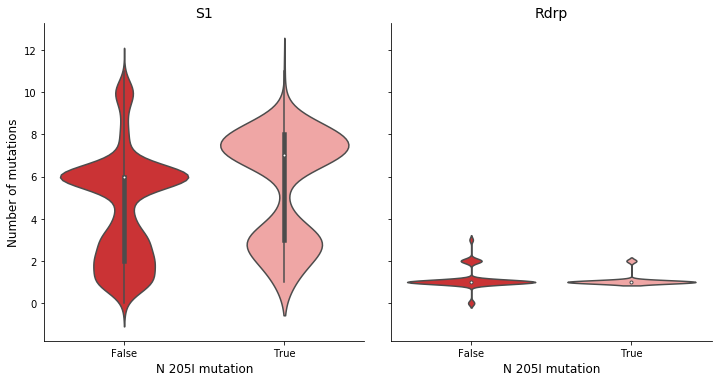

In [131]:
cmap = {True: "#fb9a99", False: "#e31a1c"}

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)
plt.tight_layout()


ax1 = sns.violinplot(x='N_205i', y='s1_mutations', 
                     hue = 'N_205i', palette = cmap, dodge = False,
                     data=date_subset, ax=ax1, legend = False)

ax2 = sns.violinplot(x='N_205i', y='rdrp_mutations', 
                     hue = 'N_205i', palette = cmap, dodge = False,
                     data=date_subset, ax=ax2, legend= False)

ax1.set_xlabel('N 205I mutation', fontsize = 12)
ax2.set_xlabel('N 205I mutation', fontsize = 12)

ax1.set_ylabel('Number of mutations', fontsize = 12)
ax2.set_ylabel('', fontsize = 12)
ax1.set_title('S1', fontsize = 14)
ax2.set_title('Rdrp', fontsize = 14)

sns.despine(left=False, bottom=False)


ax1.legend([],[], frameon=False)
ax2.legend([],[], frameon=False)



In [133]:
mean_s1_N234i = date_subset[date_subset['N_234i']==True]['s1_mutations'].mean()
mean_s1_no_N234i = date_subset[date_subset['N_234i']==False]['s1_mutations'].mean()
mean_rdrp_N234i = date_subset[date_subset['N_234i']==True]['rdrp_mutations'].mean()
mean_rdrp_no_N234i = date_subset[date_subset['N_234i']==False]['rdrp_mutations'].mean()

print(mean_s1_N234i, mean_s1_no_N234i)
print(mean_rdrp_N234i, mean_rdrp_no_N234i)

2.5294117647058822 4.738525730180807
1.911764705882353 1.1033843300880852


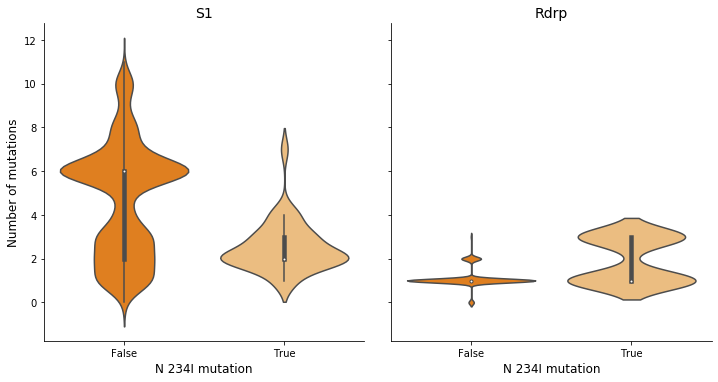

In [132]:
cmap = {True: '#fdbf6f',  False: '#ff7f00'}

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)
plt.tight_layout()


ax1 = sns.violinplot(x='N_234i', y='s1_mutations', 
                     hue = 'N_234i', palette = cmap, dodge = False,
                     data=date_subset, ax=ax1, legend = False)

ax2 = sns.violinplot(x='N_234i', y='rdrp_mutations', 
                     hue = 'N_234i', palette = cmap, dodge = False,
                     data=date_subset, ax=ax2, legend= False)

ax1.set_xlabel('N 234I mutation', fontsize = 12)
ax2.set_xlabel('N 234I mutation', fontsize = 12)

ax1.set_ylabel('Number of mutations', fontsize = 12)
ax2.set_ylabel('', fontsize = 12)
ax1.set_title('S1', fontsize = 14)
ax2.set_title('Rdrp', fontsize = 14)

sns.despine(left=False, bottom=False)


ax1.legend([],[], frameon=False)
ax2.legend([],[], frameon=False)

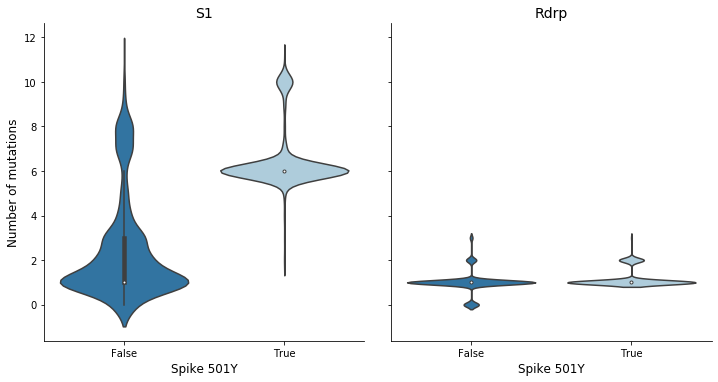

In [135]:
cmap = {True: "#a6cee3", False: "#1f78b4"}

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)
plt.tight_layout()


ax1 = sns.violinplot(x='S_501y', y='s1_mutations', 
                     hue = 'S_501y', palette = cmap, dodge = False,
                     data=to_plot_df, ax=ax1, legend = False)

ax2 = sns.violinplot(x='S_501y', y='rdrp_mutations', 
                     hue = 'S_501y', palette = cmap, dodge = False,
                     data=to_plot_df, ax=ax2, legend= False)

ax1.set_xlabel('Spike 501Y', fontsize = 12)
ax2.set_xlabel('Spike 501Y', fontsize = 12)

ax1.set_ylabel('Number of mutations', fontsize = 12)
ax2.set_ylabel('', fontsize = 12)
ax1.set_title('S1', fontsize = 14)
ax2.set_title('Rdrp', fontsize = 14)

sns.despine(left=False, bottom=False)


ax1.legend([],[], frameon=False)
ax2.legend([],[], frameon=False)

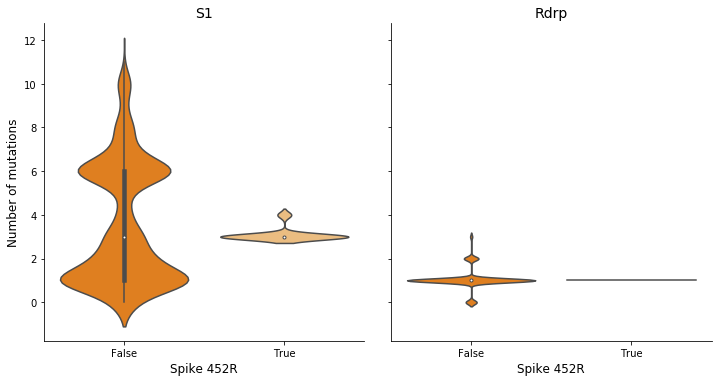

In [137]:
cmap = {True: '#fdbf6f',  False: '#ff7f00'}


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)
plt.tight_layout()


ax1 = sns.violinplot(x='S_452r', y='s1_mutations', 
                     hue = 'S_452r', palette = cmap, dodge = False,
                     data=to_plot_df, ax=ax1, legend = False)

ax2 = sns.violinplot(x='S_452r', y='rdrp_mutations', 
                     hue = 'S_452r', palette = cmap, dodge = False,
                     data=to_plot_df, ax=ax2, legend= False)

ax1.set_xlabel('Spike 452R', fontsize = 12)
ax2.set_xlabel('Spike 452R', fontsize = 12)

ax1.set_ylabel('Number of mutations', fontsize = 12)
ax2.set_ylabel('', fontsize = 12)
ax1.set_title('S1', fontsize = 14)
ax2.set_title('Rdrp', fontsize = 14)

sns.despine(left=False, bottom=False)


ax1.legend([],[], frameon=False)
ax2.legend([],[], frameon=False)